### Часть 1. Загрузка и обработка датасета

In [1]:
import pandas as pd
import numpy as np
import re
import datetime as dt
import pickle as pkl
import warnings
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb
import eli5
import seaborn
import pymorphy2
from textwrap import wrap

import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')


In [2]:
# загрузка в датасет всех ранее скачанных файлов с вакансиями

from pathlib import Path
 
directory = ''
 
df = pd.DataFrame()    
files = Path(directory).glob('vac*.pkl')
for file in files:
    print(f'Загрузка файла: {file}')
    with open(file, 'rb') as f:
        df1 = pkl.load(f)
    df = pd.concat([df, df1])
    

Загрузка файла: vac2023-05-14.pkl
Загрузка файла: vac2023-05-16.pkl
Загрузка файла: vac2023-05-17.pkl
Загрузка файла: vac2023-05-18.pkl
Загрузка файла: vac2023-05-19.pkl
Загрузка файла: vac2023-05-20.pkl
Загрузка файла: vac2023-05-21.pkl
Загрузка файла: vac2023-05-22.pkl
Загрузка файла: vac2023-05-23.pkl
Загрузка файла: vac2023-05-24.pkl
Загрузка файла: vac2023-05-25.pkl
Загрузка файла: vac2023-05-26.pkl
Загрузка файла: vac2023-05-27.pkl
Загрузка файла: vac2023-05-28.pkl
Загрузка файла: vac2023-05-29.pkl
Загрузка файла: vac_1.pkl
Загрузка файла: vac_2.pkl


In [3]:
# удаление дубликатов, id вакансии - индекс

df.drop_duplicates(subset = ['id'], inplace = True)
df.set_index('id', inplace = True)
print(f'Загружены {df.shape[0]} вакансий')


Загружены 13227 вакансий


In [4]:
pd.set_option('display.max_columns', None)
df.head()

,name,area,salary_from,salary_to,salary_currency,salary_gross,city,experience,schedule,employment,description,key_skills,accept_handicapped,professional_roles,employer,published_at,has_test,test,accept_temporary,languages
id,,,,,,,,,,,,,,,,,,,,
80352728,аналитик,Тбилиси,550.0,NaN,EUR,False,None,От 1 года до 3 лет,Полный день,Полная занятость,Одна из крупнейших транспортно-логистических к...,"[{'name': 'Внимательность'}, {'name': 'Усидчив...",False,"[{'id': '10', 'name': 'Аналитик'}]",HGFO Georgia LLC,2023-05-12T12:41:54+0300,False,None,False,None
80362648,data analyst (junior),Минск,1400.0,NaN,BYR,True,None,Нет опыта,Удаленная работа,Полная занятость,"Мы международная команда, активно растем, разв...","[{'name': 'Data Analysis'}, {'name': 'Работа с...",False,"[{'id': '10', 'name': 'Аналитик'}]",Биггико,2023-05-12T14:48:40+0300,False,None,False,None
80344751,бизнес-ассистент,Польша,1000.0,NaN,EUR,False,None,От 1 года до 3 лет,Удаленная работа,Полная занятость,"Приветствую тебя, мой ассистент и будущий напа...","[{'name': 'Тайм-менеджмент'}, {'name': 'Англий...",False,"[{'id': '10', 'name': 'Аналитик'}]",Туристическая компания Санбакс,2023-05-12T10:59:31+0300,True,True,False,None
80359825,bi-analyst,Астана,800000.0,NaN,KZT,False,Астана,От 3 до 6 лет,Полный день,Полная занятость,Обязанности: Выявление и определение потребно...,"[{'name': 'Системный анализ'}, {'name': 'Atlas...",False,"[{'id': '156', 'name': 'BI-аналитик, аналитик ...",ALLUR AUTO,2023-05-12T14:17:12+0300,False,None,False,eng b2
80253990,data scientist (intern),Москва,NaN,NaN,None,None,Москва,Нет опыта,Полный день,Стажировка,We are looking for a bright and passionate int...,"[{'name': 'Python'}, {'name': 'PyTorch'}, {'na...",False,"[{'id': '165', 'name': 'Дата-сайентист'}]",Aramco Innovations,2023-05-13T16:23:06+0300,False,None,True,eng b1


In [5]:
# чистка от спецсимволов, знаков препинания, перевод текстовых полей к нижнему регистру

df = df.replace(to_replace= '[^\\da-zA-Zа-яёА-ЯЁ\- ]', value = '', regex = True)
df[['name', 'description']] = df[['name', 'description']].apply(lambda x: x.astype(str).str.lower())


In [6]:
df.shape

(13227, 20)

In [7]:
# убираем из датасета вакансии, не касающиеся дата аналатики - системных, бизнес- и финансовых аналитиков, а также аналитиков 1С

df = df[~df['name'].apply(lambda x: any(k in x for k in ['финансовый', 'системный', 'бизнес', '1c', '1с', 'system']))]


In [8]:
dx = df.copy()

In [9]:
# убираем из текстовых полей стоп-слова

stop_words = ['по', 'с', 'и', 'в', 'г', 'со']
dx['name_2'] = dx['name'].apply(lambda x: [item for item in x.split() if item not in stop_words])


In [ ]:
# mask = dx['skill_list'].apply(lambda x: 'Навыки работы с возражениями' in x)
# dx1 = dx[mask]
# dx1.head()

In [10]:
# Лемматизируем текстовые поля
morph = pymorphy2.MorphAnalyzer()

def lemmatize(words):
    return ' '.join([morph.parse(w)[0].normal_form for w in words])

dx['name_3'] = dx['name_2'].apply(lambda x: [morph.parse(w)[0].normal_form for w in x])

In [11]:
# Переводим поля из словарей в листы

dx['skill_list'] = dx['key_skills'].apply(lambda x: [val for dic in x for val in dic.values()])
dx['role'] = dx['professional_roles'].apply(lambda x: [val for dic in x for val in dic.values()][1])


In [ ]:
# import collections
# import itertools
# x = collections.Counter(itertools.chain.from_iterable(v for v in dx['name_3']))
# x.most_common()

### Часть 2. Исследование датасета

In [12]:
# выделение датасета зарплат

salary = dx[((~dx['salary_from'].isna()) | (~dx['salary_to'].isna())) & (dx['salary_currency'] == 'RUR')][['salary_from', 'salary_to', 'salary_gross']]
print(f'Только {salary.shape[0] / dx.shape[0]:.1%} записей содержат информацию о размере зарплаты (RUR)')


Только 28.8% записей содержат информацию о размере зарплаты (RUR)


In [13]:
# обработка зарплат - перевод зарплаты до вычета налогов к зарплате после вычета налогов
# расчет диапазонов зарплат, определение типичного диапазона, расчет незаполненных значений зарплат, расчет размера "средней" 
# зарплаты для каждой вакансии, исправление зарплат ошибочно указанных в тыс. руб. 

salary['salary_from'] = np.where(salary['salary_from'] < 1000, salary['salary_from'] * 1000, salary['salary_from'])
salary['salary_to'] = np.where(salary['salary_to'] < 1000, salary['salary_to'] * 1000, salary['salary_to'])
salary['salary_from'] = np.where(salary['salary_gross'], salary['salary_from'] * 0.87, salary['salary_from'])
salary['salary_to'] = np.where(salary['salary_gross'], salary['salary_to'] * 0.87, salary['salary_to'])

salary['growth'] = (salary['salary_to'] / salary['salary_from']) - 1
print(f'Всего {salary.shape[0]} записей с указанной зарплатой, {salary[~salary["growth"].isna()].shape[0]} записей содержат и нижнюю и верхнюю границу зарплаты')

avg_sg = round(salary['growth'].mean() / 2, 2)

Всего 2641 записей с указанной зарплатой, 1035 записей содержат и нижнюю и верхнюю границу зарплаты


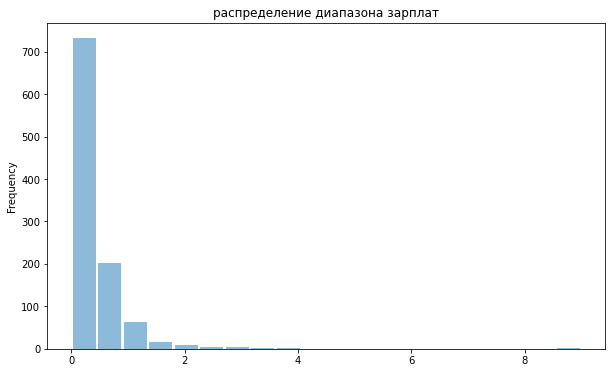

In [14]:
# Чтобы определить, как обработать записи с указанием только одной из границ зарплаты, исследуем, 
# как распределяется переменная "диапазон зарплаты"
# Эта переменная определяется как (отношение верхней границы зарплаты к нижней) минус единица

x = salary[~salary["growth"].isna()]['growth']
x.plot.hist(bins = 20, alpha = 0.5, figsize = (10, 6), zorder = 2, rwidth = 0.9, title = 'распределение диапазона зарплат');


На графике видно, что у подавляющей доли записей верхняя граница зарплаты выше нижней не более чем в два раза

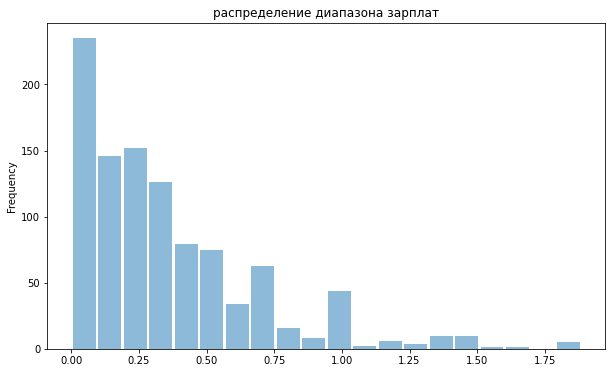

In [15]:
# ограничим верхнюю границу гистограммы

x[x < 2].plot.hist(bins = 20, alpha = 0.5, figsize = (10, 6), zorder = 2, rwidth = 0.9, title = 'распределение диапазона зарплат');

Наиболее популярным решением работодателей является указывать одно и то же значение в качестве и нижней, и верхней границ зарплат. Поэтому в тех случаях, когда верхняя граница не будет равна нижней, я буду вычислять среднее значение зарплаты, а когда указана только одна граница зарплаты, буду принимать именно ее за среднее значение. Таким образом, я получу целевую переменную для регрессионной модели. 

In [16]:
# Вычисление целевой переменной

salary['salary_from'].fillna(salary['salary_to'], inplace = True)
salary['salary_to'].fillna(salary['salary_from'], inplace = True)
salary['salary_mid'] = (salary['salary_from'] + salary['salary_to']) / 2


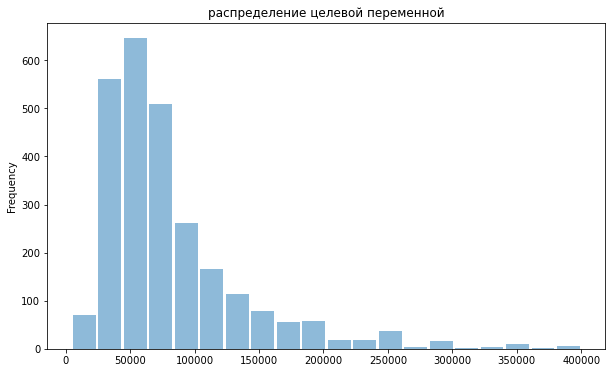

In [17]:
salary['salary_mid'].plot.hist(bins = 20, alpha = 0.5, figsize = (10, 6), zorder = 2, rwidth = 0.9, title = 'распределение целевой переменной');

Распределение зарплат имеет длинный хвост - это вполне объясняется природой переменной

In [18]:
# добавляем целевую переменную к датасету

dx = pd.merge(dx, salary[['salary_mid']], how = 'left', left_index = True, right_index = True)


In [19]:
# для обучения выделим записи датасета, в которых есть информация о зарплате

dfin = dx[dx['salary_mid'].notna()]


In [20]:
dfin.shape

(2641, 25)

In [21]:
dfin.head()

,name,area,salary_from,salary_to,salary_currency,salary_gross,city,experience,schedule,employment,description,key_skills,accept_handicapped,professional_roles,employer,published_at,has_test,test,accept_temporary,languages,name_2,name_3,skill_list,role,salary_mid
id,,,,,,,,,,,,,,,,,,,,,,,,,
80329475,специалист в аналитический отдел работа с excel,Новосибирск,45000.0,60000.0,RUR,False,Новосибирск,Нет опыта,Полный день,Полная занятость,привет мы - команда гиллион современный финанс...,"[{'name': 'Анализ данных'}, {'name': 'Управлен...",False,"[{'id': '10', 'name': 'Аналитик'}]",МКК Гиллион,2023-05-12T0636180300,False,None,False,None,"[специалист, аналитический, отдел, работа, excel]","[специалист, аналитический, отдел, работа, excel]","[Анализ данных, Управленческая отчетность, Про...",Аналитик,52500.0
80372352,аналитик,Санкт-Петербург,80000.0,80000.0,RUR,False,None,От 3 до 6 лет,Полный день,Полная занятость,вкустер - сеть ярких продуктовых магазинов фор...,"[{'name': 'Управление персоналом'}, {'name': '...",False,"[{'id': '10', 'name': 'Аналитик'}]",Вкустер,2023-05-12T1701250300,False,None,False,None,[аналитик],[аналитик],"[Управление персоналом, Управление продажами, ...",Аналитик,80000.0
80334913,специалист по работе с аналитическими данными ...,Челябинск,45000.0,NaN,RUR,False,Челябинск,От 1 года до 3 лет,Полный день,Полная занятость,обязанности подготовка внутренних документов ...,"[{'name': 'Сводные таблицы'}, {'name': 'Google...",False,"[{'id': '10', 'name': 'Аналитик'}]",ФОНД ЦЕНТР ПОДДЕРЖКИ ГРАЖДАНСКИХ ИНИЦИАТИВ И Р...,2023-05-12T0854120300,False,None,False,None,"[специалист, работе, аналитическими, данными, ...","[специалист, работа, аналитический, данные, де...","[Сводные таблицы, Google таблицы, Базы данных,...",Аналитик,45000.0
80361286,специалист по аналитике и ценообразованию,Челябинск,60000.0,NaN,RUR,False,Челябинск,От 1 года до 3 лет,Полный день,Полная занятость,обязанности управление товарными запасами на ...,"[{'name': 'Расчет премий и бонусов'}, {'name':...",False,"[{'id': '10', 'name': 'Аналитик'}]",Кондтроль,2023-05-12T1433300300,False,None,False,deu a1,"[специалист, аналитике, ценообразованию]","[специалист, аналитик, ценообразование]","[Расчет премий и бонусов, 1С: Торговля, Продви...",Аналитик,60000.0
78091528,аналитикменеджер проектаспециалист по обработк...,Тюмень,50000.0,NaN,RUR,True,Тюмень,От 3 до 6 лет,Полный день,Полная занятость,техноавиа одна из ведущих российских компаний...,"[{'name': 'Деловая переписка'}, {'name': '1С: ...",False,"[{'id': '10', 'name': 'Аналитик'}]",Техноавиа-Тюмень,2023-05-14T1545250300,False,None,False,None,"[аналитикменеджер, проектаспециалист, обработк...","[аналитикменеджер, проектаспециалист, обработк...","[Деловая переписка, 1С: Предприятие 8, Аналити...",Аналитик,43500.0


In [22]:
filename = 'vac_analysis.sav'
pkl.dump(dfin, open(filename, 'wb'))
 

In [ ]:
# with open('vac_analysis.sav', 'rb') as f:
#     df = pkl.load(f)

In [23]:
# Чтобы убедиться в том, что есть переменные, влияющие на уровень зарплаты, построим boxplots некоторых перспективных переменных:
# например: город работодателя, требуемый опыт, профессиональная роль

a = list(dfin[dfin['area'] == 'Москва']['salary_mid'])
b = list(dfin[dfin['area'] != 'Москва']['salary_mid'])
data = [a, b]

l = []
labels_e = []
for k, v in dict(list(dfin.groupby('experience')['salary_mid'])).items():
    labels_e.append(k)
    l.append(list(v))
    
l1 = []
labels_r = []
for k, v in dict(list(dfin.groupby('role')['salary_mid'])).items():
    labels_r.append(k)
    l1.append(list(v))

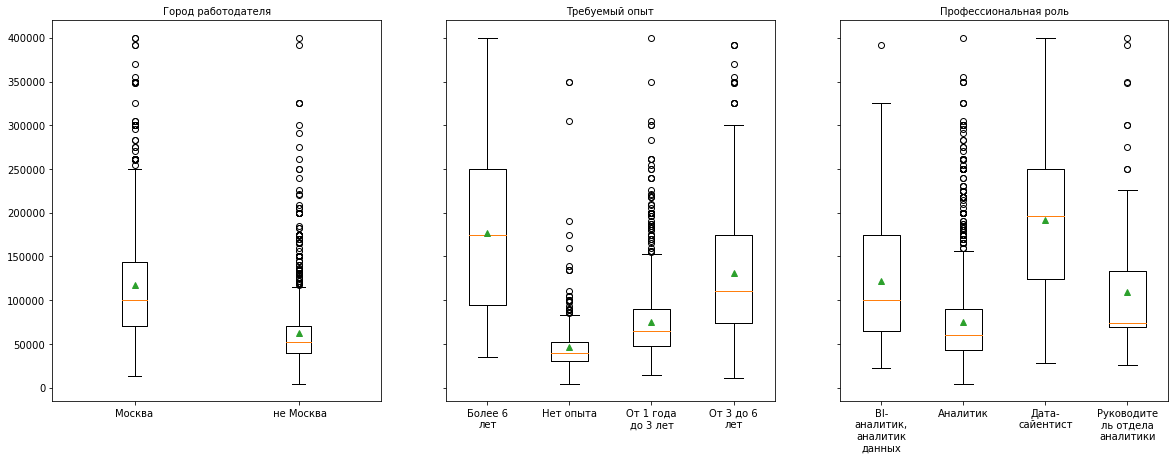

In [24]:
# отрисовка графиков

fig, axes = plt.subplots(ncols = 3, figsize = (20, 7), sharey = True)

axes[0].boxplot(data, labels = ['Москва', ' не Москва'], showmeans = True)
axes[0].set_title('Город работодателя', fontsize = 10)

labels_e = ['\n'.join(wrap(l, 10)) for l in labels_e]
axes[1].boxplot(l, labels = labels_e, showmeans = True)
axes[1].set_title('Требуемый опыт', fontsize = 10)

labels_r = ['\n'.join(wrap(l, 10)) for l in labels_r]
axes[2].boxplot(l1, labels = labels_r, showmeans = True)
axes[2].set_title('Профессиональная роль', fontsize = 10);


Приведенные выше графики указывают на возможность построения ML-модели предсказания зарплаты, т.к. существуют переменные явно влияющие на ее уровень. Видно, что зарплаты в Москве примерно в 1,5 раза выше, чем в среднем в остальных регионах. Видны явная зависимость зарплаты от опыта и ее зависимость от профессиональной роли. 

### Часть 3. Моделирование

In [25]:
# удаляем ненужные переменные, кодируем категориальные переменные 

dx.drop(['name', 'name_2', 'salary_from', 'salary_to', 'salary_currency', 'salary_gross',  'city', 'description', 'key_skills', 'professional_roles', 'employer', 'published_at'], axis = 1, inplace = True)

categorial_cols = ['area', 'experience', 'schedule', 'employment', 'accept_handicapped', 'has_test', 'test', 'accept_temporary', 'languages', 'role'] 
dx = pd.get_dummies(dx, columns = categorial_cols)


In [26]:
# кодируем переменные, которые являются перечнями 

mlb = MultiLabelBinarizer()
dx = dx.join(pd.DataFrame(mlb.fit_transform(dx.pop('name_3')), columns = mlb.classes_, index = dx.index))
dx = dx.join(pd.DataFrame(mlb.fit_transform(dx.pop('skill_list')), columns = mlb.classes_, index = dx.index), rsuffix = '_2')


In [27]:
# копируем только те записи, в которых есть целевая переменная и удаляем те переменные, в которых менее трех ненулевых значений

dfin = dx[dx['salary_mid'].notna()]
dfin = dfin[dfin.columns[dfin.sum() > 2]]
dfin = dfin * 1


In [28]:
dfin.shape

(2641, 1122)

In [29]:
filename = 'vac_full.sav'
pkl.dump(dfin, open(filename, 'wb'))
 

In [4]:
# при необходимости загрузить датасет

with open('vac_full.sav', 'rb') as f:
    dfin = pkl.load(f)

In [3]:
dfin.head()

,salary_mid,area_Алматы,area_Астрахань,area_Балашиха,area_Барнаул,area_Белгород,area_Бердск,area_Бийск,area_Благовещенск Амурская область,area_Брянск,...,машинное обучение,навыки статистической обработки данных,написание аналитических текстов,обучение сотрудников,оформление документации,прогнозирование продаж,продвинутый пользователь Excel,разработка нормативных документов,сводные таблицы,"умение работать с программами Word, Excel, Power Point"
id,,,,,,,,,,,,,,,,,,,,,
80329475,52500.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80372352,80000.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80334913,45000.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80361286,60000.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78091528,43500.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# формируем таблицу фичей и целевую переменную

X = dfin.copy()
X.drop(['salary_mid'], axis = 1, inplace = True)
y = dfin['salary_mid']


In [5]:
# нормализуем целевую переменную, сохраним максимум и минимум в файл - они нам понадобятся для прогнозирования зарплат свежих вакансий

normalized_y = (y - y.min()) / (y.max() - y.min())

with open('Salary_bounds.dat', 'wb') as fp:
    pkl.dump((y.min(), y.max()), fp)


In [6]:
# выделяем обучающую и контрольную выборки

X_train, X_test, y_train, y_test = train_test_split(X, normalized_y, test_size = 0.2, random_state = 42)


In [7]:
# записываем названия переменных в файл. Он нам понадобится для фильтрации переменных при обработке новых файлов вакансий
with open('Model_features.dat', 'wb') as fp:
    pkl.dump(X_train.columns, fp)
    

In [8]:
X_train.shape

(2112, 1121)

In [36]:
%%time
# в качестве базовой модели используем Лассо регрессор, коэффициент регуляризации подберем путем перебора

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso = Lasso(random_state = 42, max_iter = 1000, fit_intercept = False)
alphas = np.logspace(-4, -0.5, 40)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv = n_folds, refit = False)
clf.fit(X, normalized_y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']


Wall time: 1min 5s


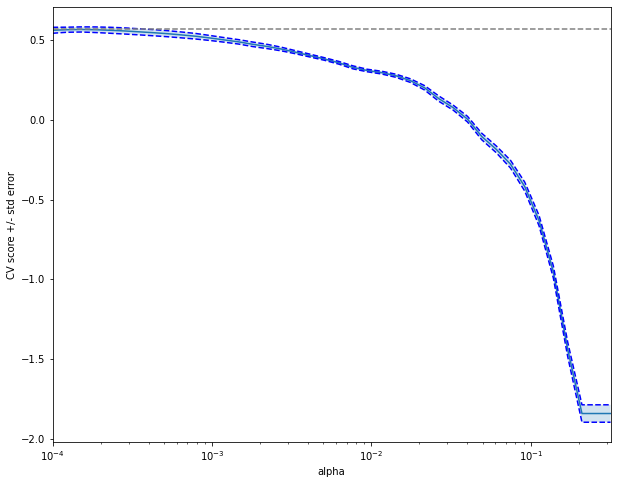

In [37]:
# график зависимости R^2 от параметра регуляризации

plt.figure().set_size_inches(10, 8)
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

plt.fill_between(alphas, scores + std_error, scores - std_error, alpha = 0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle = '--', color = '.5')
plt.xlim(alphas[0], alphas[-1]);


In [38]:
print(f'Максимум коэффициента детерминации R^2 равный {scores.max():.3} достигается при значении параметра регуляризации {alphas[scores.argmax(axis = 0)]:.5}')

Максимум коэффициента детерминации R^2 равный 0.566 достигается при значении параметра регуляризации 0.00015118


In [40]:
# пересчитаем модель с наилучшим параметром регуляризации и выведем метрики модели

lasso = Lasso(random_state = 42, max_iter = 1000, alpha = alphas[scores.argmax(axis = 0)], fit_intercept = False)
lasso.fit(X_train, y_train)

print(f'Значение коэффициента детерминации на обучающей выборке: {lasso.score(X_train, y_train):.3}')
print(f'Значение коэффициента детерминации на тестовой выборке: {lasso.score(X_test, y_test):.3}')


Значение коэффициента детерминации на обучающей выборке: 0.711
Значение коэффициента детерминации на тестовой выборке: 0.579


In [41]:
# рассчитаем метрику RMSE

pred = lasso.predict(X_test)
print(f'Оценка RMSE: {np.sqrt(mean_squared_error(y_test, pred)):.5}')


Оценка RMSE: 0.087695


In [42]:
# сохраним самые "важные" фичи модели

e_lasso = eli5.show_weights(lasso, top = -1, feature_names = X_train.columns.tolist())
top_lasso = pd.read_html(e_lasso.data)[0]
top_lasso[:5]


,Weight?,Feature
0,0.256,lead
1,0.228,исследователь
2,0.208,архитектор
3,0.199,experience_Более 6 лет
4,0.160,senior


In [43]:
# записываем модель на диск

filename = 'lasso_model.sav'
pkl.dump(lasso, open(filename, 'wb'))


In [9]:
%%time
# подбор гиперпараметров модели xgboost

xr = xgb.XGBRegressor(eval_metric = 'rmsle')
param_grid = {'max_depth' : [5, 6, 7], 
              'n_estimators' : [600, 700, 800], 
              'learning_rate' : [0.01, 0.015, 0.02]}

search = GridSearchCV(xr, param_grid, cv = 5).fit(X_train, y_train)

print(f'Лучшие гиперпараметры: {search.best_params_}')


Лучшие гиперпараметры: {'learning_rate': 0.02, 'max_depth': 7, 'n_estimators': 800}
Wall time: 29min 59s


In [10]:
# обучение финальной модели

xr = xgb.XGBRegressor(learning_rate = search.best_params_['learning_rate'], 
                      n_estimators = search.best_params_['n_estimators'],
                      max_depth = search.best_params_['max_depth'], 
                      eval_metric = 'rmse')

xr.fit(X_train, y_train); 


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=800, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [13]:
# метрики модели

print(f'Обучающая выборка R2_score: {np.sqrt(r2_score(y_train, xr.predict(X_train))):.5}')
print(f'Тестовая выборка R2_score: {np.sqrt(r2_score(y_test, xr.predict(X_test))):.5}')
RMSE = np.sqrt(mean_squared_error(y_test, xr.predict(X_test)))
print(f'Оценка : {RMSE:.5}')


Обучающая выборка R2_score: 0.94696
Тестовая выборка R2_score: 0.77386
Оценка : 0.085588


Метрика R^2, рассчитанная на обучающей и на тестовой выборках весьма сильно различается. Это говорит о том, что модель переобучилась. Для борьбы с этим явлением попробуем уменьшить параметры max_depth и learning_rate. 

In [16]:
# обучение модели с модифицированными параметрами

xr2 = xgb.XGBRegressor(learning_rate = 0.01, 
                      n_estimators = search.best_params_['n_estimators'],
                      max_depth = 4, 
                      eval_metric = 'rmse')

xr2.fit(X_train, y_train); 


In [17]:
# метрики модифицированной модели

print(f'Обучающая выборка R2_score: {np.sqrt(r2_score(y_train, xr2.predict(X_train))):.5}')
print(f'Тестовая выборка R2_score: {np.sqrt(r2_score(y_test, xr2.predict(X_test))):.5}')
RMSE = np.sqrt(mean_squared_error(y_test, xr2.predict(X_test)))
print(f'Оценка : {RMSE:.5}')


Обучающая выборка R2_score: 0.86632
Тестовая выборка R2_score: 0.75518
Оценка : 0.088583


Расхождение между метриками на обучающей и на тестовой выборках значительно снизилось, но значительно снизились и метрики качества модели. 

In [20]:
# сохраним самые "важные" фичи модели

e_xr = eli5.show_weights(xr2, top = -1, feature_names = X_train.columns.tolist())
top_xr = pd.read_html(e_xr.data)[0]
top_xr[:5]


,Weight,Feature
0,0.0619,experience_От 3 до 6 лет
1,0.0457,data
2,0.0399,area_Москва
3,0.0269,lead
4,0.0264,experience_Более 6 лет


In [21]:
# сохранение модели

filename = 'xgb_model.sav'
pkl.dump(xr2, open(filename, 'wb'))

In [2]:
#!pip install lightautoml==0.3.7.3 --user
#AutoML

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco
import torch


In [3]:
# задаем параметры алгоритма

N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 300
TARGET_NAME = 'target'

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

task = Task('reg')

roles = {'target' : TARGET_NAME}

automl = TabularAutoML(task = task, timeout = TIMEOUT, cpu_limit = N_THREADS, \
                       reader_params = {'n_jobs' : N_THREADS, 'cv' : N_FOLDS, 'random_state' : RANDOM_STATE})


In [5]:
# выделяем целевую переменную, обучающую и тестовую выборки

dfin['target'] = (dfin['salary_mid'] - dfin['salary_mid'].min()) / (dfin['salary_mid'].max() - dfin['salary_mid'].min())
dfin.drop(columns = ['salary_mid'], inplace = True)

train_data, test_data = train_test_split(dfin, test_size = TEST_SIZE, random_state = RANDOM_STATE)
print(f'Размер обучающей выборки: {train_data.shape}, тестовой выборки: {test_data.shape}')


Размер обучающей выборки: (2112, 1122), тестовой выборки: (529, 1122)


In [6]:
%%time
# обучение модели

oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 1)


[08:38:15] Stdout logging level is INFO.
[08:38:15] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[08:38:15] Task: reg

[08:38:15] Start automl preset with listed constraints:
[08:38:15] - time: 300.00 seconds
[08:38:15] - CPU: 4 cores
[08:38:15] - memory: 16 GB

[08:38:15] Train data shape: (2112, 1122)

[08:38:20] Layer 1 train process start. Time left 295.05 secs
[08:38:20] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[08:38:21] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.010027894959618327
[08:38:21] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[08:38:21] Time left 293.45 secs

[08:38:22] Selector_LightGBM fitting and predicting completed
[08:38:23] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[08:38:25] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.009070555700861576
[08:38:25] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[08:38:25] Start hyperparameters optimization for 

In [9]:
# метрики модели

test_pred = automl.predict(test_data)
print(f'Обучающая выборка R2_score: {np.sqrt(r2_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])):.5}')
print(f'Тестовая выборка R2_score: {np.sqrt(r2_score(test_data[TARGET_NAME].values, test_pred.data[:, 0])):.5}')
RMSE = np.sqrt(mean_squared_error(test_data[TARGET_NAME].values, test_pred.data[:, 0]))
print(f'Оценка : {RMSE:.5}')


Обучающая выборка R2_score: 0.79368
Тестовая выборка R2_score: 0.76281
Оценка : 0.08738


In [11]:
# описание подобранной модели

print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.26577 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.34546 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.17192 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.21684 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


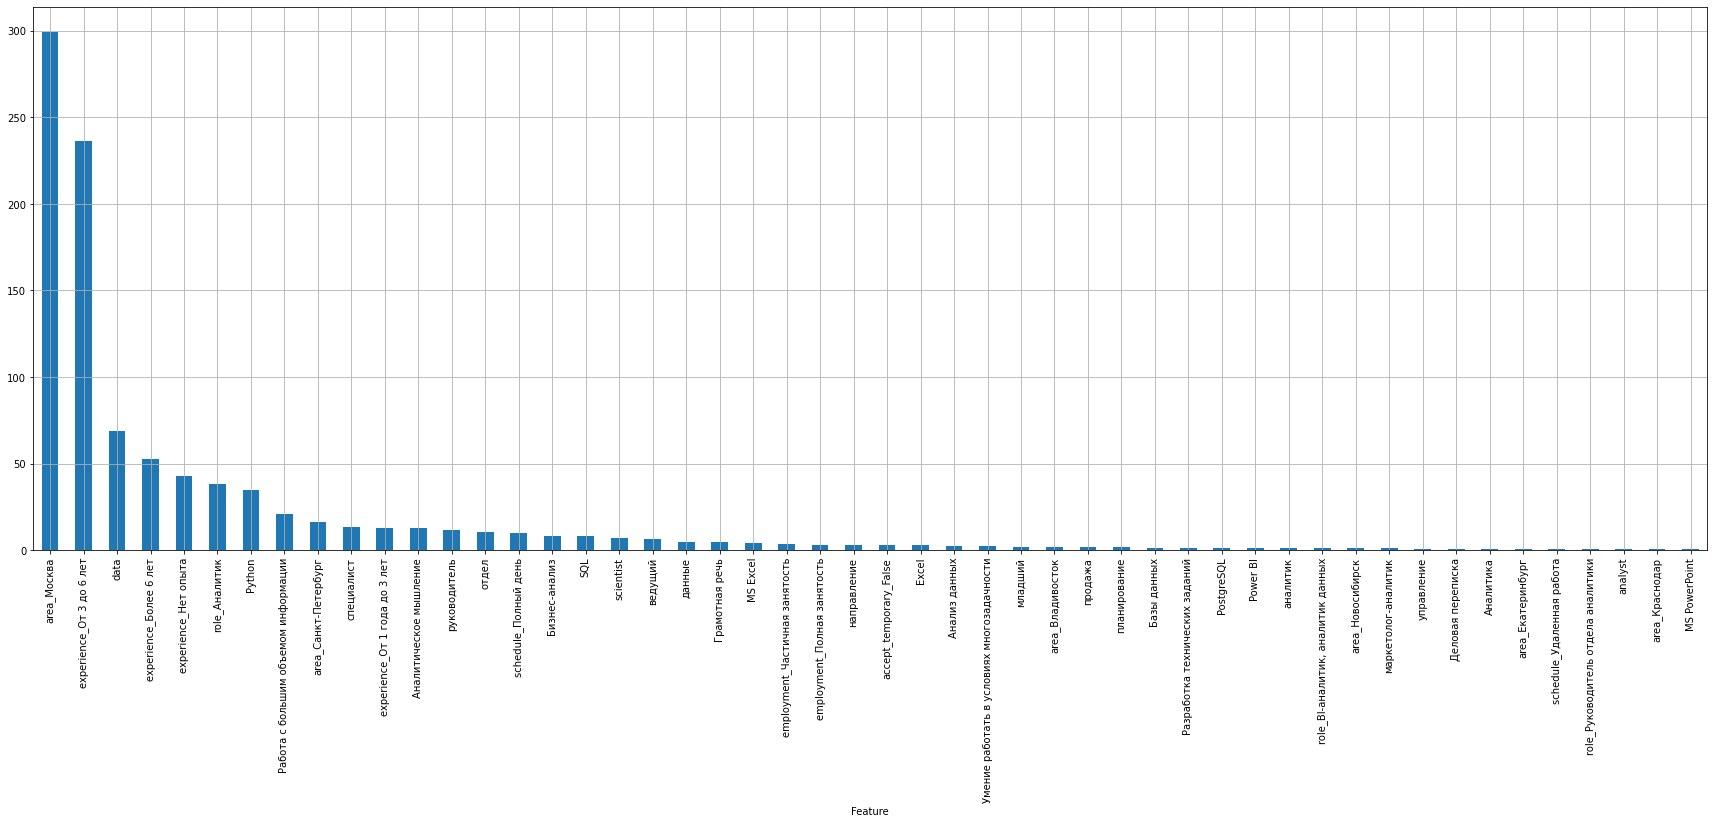

In [14]:
# Выведем на график самые важные фичи модели

fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'][:50].plot.bar(figsize = (30, 10), grid = True);

In [15]:
# сохранение модели

filename = 'aml_model.sav'
pkl.dump(automl, open(filename, 'wb'))

Результаты построения трех моделей: модели Lasso и xgboost переобучились, их можно регуляризировать, но тогда это даст метрики моделей, которые будут хуже метрик модели LightAutoML. Последняя модель сразу обучилась хорошо (метрики на обучающей и тестовой выборках близки по своим значениям), поэтому ее можно выбрать для дальнейшего использования. 